## Predicting House Prices using Machine Learning 
- (Linear Regression Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

data = pd.read_csv("AmesHousing.tsv", delimiter = "\t")

data.shape[0]

2930

In [2]:
def transform_features(df):
    
    df["Years Until Remod"] = df["Year Remod/Add"] - df["Year Built"]
    df["Years Until Sold"] = df["Yr Sold"] - df["Year Built"]
    df["Years Since Remod"] = df["Yr Sold"] - df["Year Remod/Add"]
    neg_rows = (df["Years Until Remod"] < 0) | (df["Years Until Sold"] < 0) | (df["Years Since Remod"] < 0)
    df = df.drop(df.loc[neg_rows, :].index, axis = 0)
    drop_cols = ["Order", "PID", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"]
    df = df.drop(drop_cols, axis = 1)
    
    cond_drop = df.isnull().sum() > df.shape[0] * 0.05
    df = df.drop(df.loc[:,cond_drop].columns, axis = 1)
    
    text_df = df.select_dtypes(include = ["object"])
    text_cols_cond = text_df.isnull().sum() > 0
    df = df.drop(text_df.loc[:, text_cols_cond].columns, axis = 1)
    
    cond_repl = (df.isnull().sum() <= df.shape[0] * 0.05)
    df.loc[:, cond_repl] = df.loc[:, cond_repl].fillna(df.loc[:, cond_repl].mode().iloc[0])  
    
    return df

In [3]:
def select_features(transformed_df):
    #All nominal columns
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    #Now we drop all categorical columns that have more than 10 individual values
    #and where 90 or more percent of values are identical
    
    nominals = []
    for col in nominal_features:
        if col in transformed_df.columns:
            transformed_df[col] = transformed_df[col].astype("category")
            #this will filter out every category with more than 15 values
            val_series = transformed_df[col].cat.codes.value_counts()
            if len(val_series) <= 10:
                # to check wether most values are identical:
                if True not in (val_series > (val_series.sum() * 0.90)).values:
                    nominals.append(col)
    
    #Adding the Neigborhood category as it seems to be a good way of grouping
    #house prices
    nominals.append("Neighborhood")
    
    #finally getting the dummy variables and adding them to our dataframe
    dummy_cols = []
    for col in nominals:
        if col in transformed_df.columns:
            dummies = pd.get_dummies(transformed_df[col])
            dummy_cols += list(dummies.columns)
            transformed_df = pd.concat([transformed_df, dummies], axis = 1)
            transformed_df = transformed_df.drop([col], axis = 1)
    
   
   
    # Now filtering for numeric columns with correlations > 0.4 (positive/negative)
    numeric_df = transformed_df.select_dtypes(include = ["int", "float"])
    price_corrs = abs(numeric_df.corr().loc[:, "SalePrice"]).sort_values(ascending = False)
    cols = list(price_corrs[price_corrs > 0.4].index)
    
    # finally remove colums with correlations to other features:
    prob_cols = ["Garage Area", "TotRms AbvGrd", "Full Bath"]
    cols = [item for item in cols if item not in prob_cols]
    
    #return both the numeric feature columns aswell as our categorical dummies:
    features = cols + dummy_cols
    
    return transformed_df.loc[:, features]

In [4]:
def train_and_test(df, k):
   
    feature_df = transform_features(df)
    feature_df = select_features(feature_df)
    features = list(feature_df.drop(["SalePrice"], axis = 1).columns)
    
    if k == 0:
        split_idx = int(feature_df.shape[0]/2)
        train = feature_df[:split_idx]
        test = feature_df[split_idx:]
        
        lr = LinearRegression()
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
    
        rmse = (mean_squared_error(test["SalePrice"], predictions)) ** 0.5
        
        return rmse
    
    if k == 1:
        np.random.seed(1)
        randomdf = feature_df.sample(frac = 1)
        split_idx = int(feature_df.shape[0]/2)
        train = randomdf[:split_idx]
        test = randomdf[split_idx:]
        
        lr = LinearRegression()
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
    
        rmse = (mean_squared_error(test["SalePrice"], predictions)) ** 0.5
       
        return rmse
    
    if k > 1:
        lr = LinearRegression()
        kf = KFold(n_splits = k, shuffle = True, random_state = 1) # remove randomseed 
        mses = cross_val_score(lr, feature_df[features], feature_df["SalePrice"] ,scoring = "neg_mean_squared_error", cv = kf)
        rmses = abs(mses) ** 0.5
        print(rmses)
        return np.mean(rmses)
    
    else:
        print("wrong k given")

<b>Testing the model with holdout validation:

In [24]:
train_and_test(data, 0)

32424.117008376528

<b>Testing the model with cross validation:

In [5]:
train_and_test(data, 1)

28339.030417951741

<b>Testing the model using K-Fold cross validation:

In [25]:
train_and_test(data, 10)

[ 34636.66557789  46366.25365904  23978.92060182  21709.42258943
  28367.84557022  30195.74152086  22375.54830921  27341.21622885
  26043.21617654  28072.63210114]


28908.7462334995

## The Cells below were used to experiment. Afterwards the functions above were updated accordingly.

<b>Feature Engineering: </b>
- this will be included in the transform_features function

In [7]:
df = data.copy()
df["Years Until Remod"] = df["Year Remod/Add"] - df["Year Built"]
df["Years Until Sold"] = df["Yr Sold"] - df["Year Built"]
df["Years Since Remod"] = df["Yr Sold"] - df["Year Remod/Add"]
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Until Remod,Years Until Sold,Years Since Remod
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,0,5,2010,WD,Normal,215000,0,50,50
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,0,6,2010,WD,Normal,105000,0,49,49
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,Gar2,12500,6,2010,WD,Normal,172000,0,52,52


In [8]:
df.loc[df["Years Until Remod"] < 0, :]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Until Remod,Years Until Sold,Years Since Remod
850,851,907194160,20,RL,65.0,10739,Pave,NaN,IR1,Lvl,...,NaN,0,4,2009,WD,Normal,203000,-1,7,8


In [9]:
df.loc[df["Years Since Remod"] < 0, :]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Until Remod,Years Until Sold,Years Since Remod
1702,1703,528120010,60,RL,134.0,16659,Pave,NaN,IR1,Lvl,...,NaN,0,6,2007,New,Partial,260116,1,0,-1
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,Elev,17000,10,2007,New,Partial,183850,1,-1,-2
2181,2182,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,...,NaN,0,10,2007,New,Partial,184750,1,0,-1


In [10]:
df.loc[df["Years Until Sold"] < 0, :]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Until Remod,Years Until Sold,Years Since Remod
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,Elev,17000,10,2007,New,Partial,183850,1,-1,-2


In [11]:
# dropping rows that have values < 0
df = df.drop([850, 1702, 2180, 2181], axis = 0)

In [12]:
# dropping columns that are not useful:
drop_cols = ["Order", "PID", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"]
df = df.drop(drop_cols, axis = 1)

<b>Feature Selection

In [13]:
transformed_df = transform_features(data)

In [14]:
# some columns are numerical but have no numeric meaning (e.g MSSubclass)
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [15]:
nominals = []
for col in nominal_features:
    if col in transformed_df.columns:
        transformed_df[col] = transformed_df[col].astype("category")
        #this will filter out every category with more than 15 values
        val_series = transformed_df[col].cat.codes.value_counts()
        if len(val_series) <= 10:
            # to check wether most values are identical:
            if True not in (val_series > (val_series.sum() * 0.90)).values:
                nominals.append(col)
        
nominals.append("Neighborhood")
nominals

['MS Zoning',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Foundation',
 'Neighborhood']

In [16]:
dummy_cols = []
for col in nominals:
    if col in transformed_df.columns:
        dummies = pd.get_dummies(transformed_df[col])
        dummy_cols += list(dummies.columns)
        dummy_cols += list(dummies.columns)
        transformed_df = pd.concat([transformed_df, dummies], axis = 1)
        transformed_df = transformed_df.drop([col], axis = 1)

In [17]:
# Getting the corellations with SalePrice
numeric_df = transformed_df.select_dtypes(include = ["int", "float"])
price_corrs = abs(numeric_df.corr().loc[:, "SalePrice"]).sort_values(ascending = False)
price_corrs

SalePrice            1.000000
Overall Qual         0.801212
Gr Liv Area          0.717617
Garage Cars          0.648351
Total Bsmt SF        0.644023
Garage Area          0.641414
1st Flr SF           0.635183
Years Until Sold     0.558984
Full Bath            0.546108
Years Since Remod    0.534972
Mas Vnr Area         0.507010
TotRms AbvGrd        0.498614
Fireplaces           0.474994
BsmtFin SF 1         0.439365
Wood Deck SF         0.328158
Open Porch SF        0.316277
Half Bath            0.284974
Bsmt Full Bath       0.276214
2nd Flr SF           0.269707
Lot Area             0.267517
Years Until Remod    0.240017
Bsmt Unf SF          0.182862
Bedroom AbvGr        0.143902
Enclosed Porch       0.128656
Kitchen AbvGr        0.119743
Screen Porch         0.112310
Overall Cond         0.101498
Pool Area            0.068445
Low Qual Fin SF      0.037620
Bsmt Half Bath       0.035852
3Ssn Porch           0.032279
Yr Sold              0.030450
Misc Val             0.019264
BsmtFin SF

In [18]:
# keep columns with corellations higher than 0.4
cols = list(price_corrs[price_corrs > 0.4].index)
#cols = cols.remove("Garage Yr Built")
cols

['SalePrice',
 'Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Total Bsmt SF',
 'Garage Area',
 '1st Flr SF',
 'Years Until Sold',
 'Full Bath',
 'Years Since Remod',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'BsmtFin SF 1']

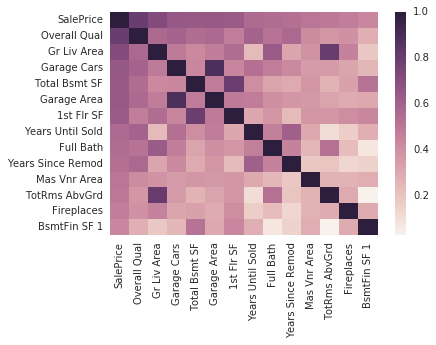

In [19]:
correlations = abs(numeric_df.corr()).loc[cols, cols]

%matplotlib inline
sns.heatmap(correlations)
plt.show()

In [20]:
#Now remove features that have high corellations with other features:
prob_cols = ["Garage Area", "TotRms AbvGrd", "Full Bath"]
cols = [item for item in cols if item not in prob_cols]

In [21]:
features = cols + dummy_cols

In [22]:
sum(transformed_df[features].isnull().sum())

0

<b>updating for k-fold cross validation:

In [23]:
'''
def train_and_test(df, target, k):
   
    feature_df = transform_features(df)
    feature_df = select_features(feature_df)
    features = list(feature_df.drop([target], axis = 1).columns)
    
    if k == 0:
        split_idx = int(feature_df.shape[0]/2)
        train = feature_df[:split_idx]
        test = feature_df[split_idx:]
        
        lr = LinearRegression()
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
    
        rmse = (mean_squared_error(test[target], predictions)) ** 0.5
        
        return rmse
    
    if k == 1:
        np.random.seed(1)
        randomdf = feature_df.sample(frac = 1)
        split_idx = int(feature_df.shape[0]/2)
        train = randomdf[:split_idx]
        test = randomdf[split_idx:]
        
        lr = LinearRegression()
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
    
        rmse = (mean_squared_error(test[target], predictions)) ** 0.5
       
        return rmse
    
    if k > 1:
        lr = LinearRegression()
        kf = KFold(n_splits = k, shuffle = True, random_state = 1) # remove randomseed 
        mses = cross_val_score(lr, feature_df[features], feature_df[target] ,scoring = "neg_mean_squared_error", cv = kf)
        rmses = abs(mses) ** 0.5
        print(rmses)
        return np.mean(rmses)
    
    else:
        print("wrong k given")
'''
print("end")

end
